## IMPORT LIBRARES AND PACKAGES

In [206]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, cv2

## [1] DATA PREPARATION

Setup data directory

In [207]:
IMAGE_DIRECTORY = "./cohn-kanade-images/"
DATA_LABEL_DIRECTORY = "./data_labels.csv"

#### Load Label Dataset

In [208]:
df = pd.read_csv(DATA_LABEL_DIRECTORY)

Explore head

In [209]:
df.head(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
0,S005,1,11,./cohn-kanade-images/S005/001/S005_001_0000001...,S005_001_00000011,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
1,S010,1,14,./cohn-kanade-images/S010/001/S010_001_0000001...,S010_001_00000014,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
2,S010,2,14,./cohn-kanade-images/S010/002/S010_002_0000001...,S010_002_00000014,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,surprise
3,S010,3,18,./cohn-kanade-images/S010/003/S010_003_0000001...,S010_003_00000018,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,negative
4,S010,4,19,./cohn-kanade-images/S010/004/S010_004_0000001...,S010_004_00000019,1,0,0,0,0,...,1,1,1,0,0,0,0,0,0,negative


Explore Tail

In [210]:
df.tail(5)

,subject,sequence,image_index,filepath,file_prefix,AU17,AU1,AU2,AU25,AU27,...,AU7,AU23,AU24,AU6,AU12,AU15,AU14,AU11,AU26,high_level_emotion
555,S506,4,38,./cohn-kanade-images/S506/004/S506_004_0000003...,S506_004_00000038,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,negative
556,S506,6,42,./cohn-kanade-images/S506/006/S506_006_0000004...,S506_006_00000042,1,1,1,0,0,...,0,0,0,0,0,1,0,0,1,negative
557,S895,2,7,./cohn-kanade-images/S895/002/S895_002_0000000...,S895_002_00000007,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,negative
558,S999,1,18,./cohn-kanade-images/S999/001/S999_001_0000001...,S999_001_00000018,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,negative
559,S999,3,55,./cohn-kanade-images/S999/003/S999_003_0000005...,S999_003_00000055,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,negative


#### [1.2] DATA INTEGRITY CHECKING

Check Duplicate

In [211]:
print('Number of duplicated rows:', df.duplicated().sum())

Number of duplicated rows: 0


Check Nan Value

In [212]:
print('Number of Nan value rows:\n', df.isnull().sum())

Number of Nan value rows:
 subject               0
sequence              0
image_index           0
filepath              0
file_prefix           0
AU17                  0
AU1                   0
AU2                   0
AU25                  0
AU27                  0
AU4                   0
AU7                   0
AU23                  0
AU24                  0
AU6                   0
AU12                  0
AU15                  0
AU14                  0
AU11                  0
AU26                  0
high_level_emotion    0
dtype: int64


Check Data Overall 

In [213]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560 entries, 0 to 559
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   subject             560 non-null    object
 1   sequence            560 non-null    int64 
 2   image_index         560 non-null    int64 
 3   filepath            560 non-null    object
 4   file_prefix         560 non-null    object
 5   AU17                560 non-null    int64 
 6   AU1                 560 non-null    int64 
 7   AU2                 560 non-null    int64 
 8   AU25                560 non-null    int64 
 9   AU27                560 non-null    int64 
 10  AU4                 560 non-null    int64 
 11  AU7                 560 non-null    int64 
 12  AU23                560 non-null    int64 
 13  AU24                560 non-null    int64 
 14  AU6                 560 non-null    int64 
 15  AU12                560 non-null    int64 
 16  AU15                560 no

## [2] EXPLORATORY DATA ANALYSIS

Check Label Count

/var/folders/fw/d2x7nnxd3f90qrnsdxzvsjqw0000gn/T/ipykernel_37991/92275530.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls')


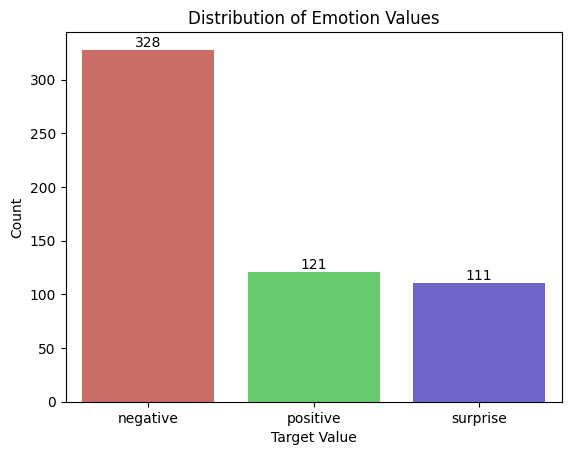

In [214]:
# Get the counts of each target value
target_value_counts = df['high_level_emotion'].value_counts()

# Create a bar plot
ax = sns.barplot(x=target_value_counts.index, y=target_value_counts.values, palette='hls')

# Show the number of observations inside each bar
for container in ax.containers:
    ax.bar_label(container, fmt='%d')

plt.xlabel('Target Value')
plt.ylabel('Count')
plt.title('Distribution of Emotion Values')
plt.show()

**Observation**

It seems there are unbalanced count of negative comparing to other label

## [3] SETUP AND EXTRACT ESSENTIAL DATA 

#### Load Image Dataset

In [215]:
# Initialize an empty list to store processed images
img_data_list = []

# Get a list of image file paths from the 'filepath' column in the DataFrame
img_file_list = df['filepath'].tolist()

# Iterate through each image file path
for img in img_file_list:
    input_img = cv2.imread(img)

    ### GrayScale ?
    grayscaled_image = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

    # Resize the image to a fixed size of 48x48 pixels
    input_img_resize=cv2.resize(grayscaled_image,(48,48))

    # Normalize the image pixel values to lie between 0 and 1
    normalized_image = input_img_resize / 255.0

    ### Expanded ? 
    expanded_image = np.expand_dims(normalized_image, axis=-1)

    img_data_list.append(expanded_image)

# Convert the list of resized images to a NumPy array
img_data = np.array(img_data_list)
# Convert the data type of pixel values to 'float32'
img_data = img_data.astype('float32')

# Check Shape
# 560 images.
# 48 pixels in height.
# 48 pixels in width.
# 1 since the image are grayscaled.
img_data.shape

(560, 48, 48, 1)

#### Load Label

In [216]:
# Define mapping conversion
target_mapping = {'negative': 0, 'positive': 1, 'surprise': 2}
df['high_level_emotion_num'] = df['high_level_emotion'].map(target_mapping)
labels = df['high_level_emotion_num'].to_list()
len(labels)

560

#### Load FACS CODE

In [217]:
facs_code_list = []
for i in range(df.shape[0]):
    facs_code_row = df.iloc[i, 5:20].tolist()
    facs_code_list.append(facs_code_row)
len(facs_code_list)

560

### [3.1] FEATURE EXTRACTION

In [218]:
from keras.utils import to_categorical
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [219]:
names = ['negative','positive','surprise']

def getLabel(id):
    return ['negative','positive','surprise'][id]

Extract indices 

In [220]:
num_classes = 3
Y = to_categorical(labels, num_classes=num_classes)
# x,y = shuffle(img_data, Y, random_state=2)
# x.shape, y.shape